In [9]:
from PIL import Image
import requests
from typing import Sequence
from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

from datasets import load_dataset

XVIEW = load_dataset("HichTala/xview")

In [3]:
XVIEW

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 20881
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 2762
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 2326
    })
})

In [33]:
classes = XVIEW["train"].features["objects"].feature["category"].names
print(classes)
print(len(classes))

['Fixed-wing Aircraft', 'Small Aircraft', 'Cargo Plane', 'Helicopter', 'Passenger Vehicle', 'Small Car', 'Bus', 'Pickup Truck', 'Utility Truck', 'Truck', 'Cargo Truck', 'Truck w/Box', 'Truck Tractor', 'Trailer', 'Truck w/Flatbed', 'Truck w/Liquid', 'Crane Truck', 'Railway Vehicle', 'Passenger Car', 'Cargo Car', 'Flat Car', 'Tank car', 'Locomotive', 'Maritime Vessel', 'Motorboat', 'Sailboat', 'Tugboat', 'Barge', 'Fishing Vessel', 'Ferry', 'Yacht', 'Container Ship', 'Oil Tanker', 'Engineering Vehicle', 'Tower crane', 'Container Crane', 'Reach Stacker', 'Straddle Carrier', 'Mobile Crane', 'Dump Truck', 'Haul Truck', 'Scraper/Tractor', 'Front loader/Bulldozer', 'Excavator', 'Cement Mixer', 'Ground Grader', 'Hut/Tent', 'Shed', 'Building', 'Aircraft Hangar', 'Damaged Building', 'Facility', 'Construction Site', 'Vehicle Lot', 'Helipad', 'Storage Tank', 'Shipping container lot', 'Shipping Container', 'Pylon', 'Tower']
60


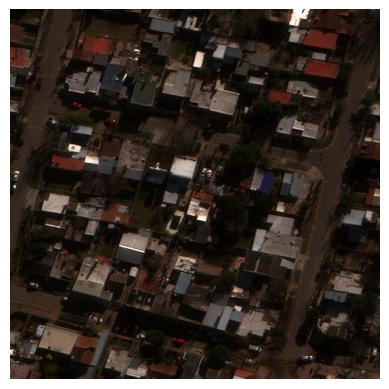

{'image_id': 20540, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x168EC3DD0>, 'width': 512, 'height': 512, 'objects': {'bbox_id': [775025, 775026, 775027, 775028, 775029, 775030, 775031, 775032, 775033, 775034, 775035, 775036, 775037, 775038, 775039, 775040, 775041, 775042, 775043, 775044, 775045, 775046, 775047, 775048, 775049, 775050, 775051, 775052, 775053, 775054, 775055, 775056, 775057, 775058, 775059, 775060, 775061, 775062, 775063, 775064, 775065, 775066, 775067, 775068, 775069, 775070, 775071, 775072, 775073, 775074, 775075, 775076, 775077, 775078, 775079, 775080, 775081, 775082, 775083, 775084, 775085, 775086, 775087, 775088, 775089, 775090, 775091, 775092, 775093, 775094, 775095, 775096, 775097, 775098, 775099, 775100, 775101, 775102, 775103, 775104, 775105, 775106, 775107, 775108, 775109, 775110, 775111, 775112, 775113, 775114, 775115, 775116, 775117, 775118, 775119, 775120, 775121, 775122, 775123, 775124, 775125, 775126, 775127, 775128, 775129

In [32]:
# pick a random image from the dataset
import random
import matplotlib.pyplot as plt


def get_labels(sample):
    return list(set([classes[i] for i in sample["objects"]["category"]]))


random_index = random.randint(0, len(XVIEW["train"]))
sample = XVIEW["train"][random_index]
plt.imshow(sample["image"])
plt.axis("off")
plt.show()
print(sample)
# labels = set([classes[i] for i in sample["objects"]["category"]])
labels = get_labels(sample)
print(labels)


In [70]:
# predict label of the image
inputs = processor(
    text=classes, images=sample["image"], return_tensors="pt", padding=True
)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1).detach().numpy()

# print prob of all classes from highest to lowest prob
for i in probs.argsort()[0][::-1]:
    print(f"{classes[i]:<15} {probs[0][i]:.2f}")


Vehicle Lot     0.21
Damaged Building 0.11
Helipad         0.11
Shipping container lot 0.10
Storage Tank    0.06
Small Aircraft  0.05
Building        0.04
Cargo Plane     0.04
Aircraft Hangar 0.04
Facility        0.03
Fixed-wing Aircraft 0.03
Construction Site 0.03
Helicopter      0.01
Cargo Car       0.01
Shed            0.01
Pylon           0.01
Shipping Container 0.01
Small Car       0.01
Tower           0.01
Truck w/Box     0.01
Cargo Truck     0.01
Cement Mixer    0.01
Straddle Carrier 0.01
Hut/Tent        0.01
Passenger Vehicle 0.00
Trailer         0.00
Tank car        0.00
Truck w/Flatbed 0.00
Mobile Crane    0.00
Truck           0.00
Bus             0.00
Flat Car        0.00
Engineering Vehicle 0.00
Tower crane     0.00
Utility Truck   0.00
Scraper/Tractor 0.00
Dump Truck      0.00
Barge           0.00
Truck w/Liquid  0.00
Pickup Truck    0.00
Crane Truck     0.00
Maritime Vessel 0.00
Truck Tractor   0.00
Railway Vehicle 0.00
Container Crane 0.00
Tugboat         0.00
Oil Tanker

In [40]:
# calculate prediction accuracy on the validation dataset
from tqdm import tqdm

text_to_predict = [f"A satellite photo containing {c}" for c in classes]

correct = 0
total = 0
for sample in tqdm(XVIEW["validation"]):
    inputs = processor(
        text=text_to_predict, images=sample["image"], return_tensors="pt", padding=True
    )
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1).detach().numpy()
    # top ten predictions
    target_labels = get_labels(sample)
    preds = probs.argsort()[0][::-1][:10]
    if any([classes[p] in target_labels for p in preds]):
        # print(f"{target_labels}->{[classes[p] for p in preds]}")
        # plt.imshow(sample["image"])
        # break
        correct += 1
    else:
        # print predicted prob vs actual prob
        # print(f"Predicted: {classes[pred]} ({probs[0][pred]:.2f})")
        # print(f"Actual: {classes[sample['label']]} ({probs[0][sample['label']]:.2f})")
        # print(f"{target_labels}->{[classes[p] for p in preds]}")
        pass
    total += 1
    # if total == 100:
    #     break

print(f"Accuracy: {correct} / {total} = {correct / total:.2f}")

100%|██████████| 2762/2762 [04:15<00:00, 10.82it/s]

Accuracy: 1983 / 2762 = 0.72


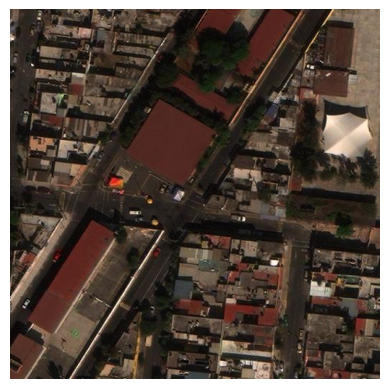

{'image_id': 8033, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512 at 0x16D20A8D0>, 'width': 512, 'height': 512, 'objects': {'bbox_id': [290970, 290971, 290972, 290973, 290974, 290975, 290976, 290977, 290978, 290979, 290980, 290981, 290982, 290983, 290984, 290985, 290986, 290987, 290988, 290989, 290990, 290991, 290992, 290993, 290994, 290995, 290996, 290997, 290998, 290999, 291000, 291001, 291002, 291003, 291004, 291005, 291006, 291007, 291008, 291009, 291010, 291011, 291012, 291013, 291014, 291015, 291016, 291017, 291018, 291019, 291020, 291021, 291022, 291023, 291024, 291025, 291026, 291027, 291028, 291029, 291030, 291031, 291032, 291033, 291034, 291035, 291036, 291037, 291038, 291039, 291040, 291041, 291042, 291043, 291044, 291045, 291046, 291047, 291048, 291049, 291050, 291051, 291052, 291053, 291054, 291055, 291056, 291057, 291058, 291059, 291060, 291061, 291062, 291063, 291064, 291065, 291066, 291067, 291068, 291069, 291070, 291071, 291072, 291073], 'categ

In [75]:
random_index = random.randint(0, len(XVIEW["train"]))
sample = XVIEW["train"][random_index]
plt.imshow(sample["image"])
plt.axis("off")
plt.show()
print(sample)
labels = get_labels(sample)
print(labels)

In [76]:
inputs = processor(
    text=classes, images=sample["image"], return_tensors="pt", padding=True
)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1).detach().numpy()
# print(probs)
# get indices of top 10 predictions
preds = probs.argsort()[0][::-1][:10]
# print prob of all classes from highest to lowest prob
# print(preds)
latex = ""
for i in preds:
    pb = f"{100 * probs[0][i]:.0f}\\%"
    line = f"{pb:<5} {classes[i]} \\\\"
    latex += line + " "
    print(line)

print(latex)


24\%  Shipping container lot \\
16\%  Helipad \\
10\%  Vehicle Lot \\
6\%   Storage Tank \\
3\%   Shipping Container \\
3\%   Construction Site \\
3\%   Small Car \\
3\%   Small Aircraft \\
2\%   Cargo Plane \\
2\%   Cargo Truck \\
24\%  Shipping container lot \\ 16\%  Helipad \\ 10\%  Vehicle Lot \\ 6\%   Storage Tank \\ 3\%   Shipping Container \\ 3\%   Construction Site \\ 3\%   Small Car \\ 3\%   Small Aircraft \\ 2\%   Cargo Plane \\ 2\%   Cargo Truck \\ 


In [77]:
# calculate prediction accuracy on the validation dataset
from tqdm import tqdm

text_to_predict = [f"A satellite photo containing {c}" for c in classes]

correct = 0
total = 0
for sample in tqdm(XVIEW["validation"]):
    inputs = processor(
        text=text_to_predict, images=sample["image"], return_tensors="pt", padding=True
    )
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=1).detach().numpy()
    # top ten predictions
    target_labels = get_labels(sample)
    preds = probs.argsort()[0][::-1][:10]
    # all target labels are in the top 10 predictions
    if all([any([classes[p] == tl for p in preds]) for tl in target_labels]):
        # print(f"{target_labels}->{[classes[p] for p in preds]}")
        # plt.imshow(sample["image"])
        # break
        correct += 1
    else:
        # print predicted prob vs actual prob
        # print(f"Predicted: {classes[pred]} ({probs[0][pred]:.2f})")
        # print(f"Actual: {classes[sample['label']]} ({probs[0][sample['label']]:.2f})")
        # print(f"{target_labels}->{[classes[p] for p in preds]}")
        pass
    total += 1
    # if total == 100:
    #     break

print(f"Accuracy: {correct} / {total} = {correct / total:.2f}")

100%|██████████| 2762/2762 [04:14<00:00, 10.86it/s]

Accuracy: 380 / 2762 = 0.14
